In [1]:
import numpy as np
from numba import jit
from scipy.ndimage import label
from tifffile import imread, imsave
from glob import glob
from scipy import ndimage
from skimage.measure import label

In [2]:
@jit
def pixel_sharing_bipartite(lab1, lab2):
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max()+1, lab2.max()+1), dtype=np.int)
    for i in range(lab1.size):
        psg[lab1.flat[i], lab2.flat[i]] += 1
    return psg

In [3]:
def matching_iou(psg, fraction=0.5):
    iou = intersection_over_union(psg)
    matching = iou > 0.5
    matching[:,0] = False
    matching[0,:] = False
    return matching

In [4]:
def matching_max(psg):
    """
    matching based on mutual first preference
    """
    rowmax = np.argmax(psg, axis=0)
    colmax = np.argmax(psg, axis=1)
    starting_index = np.arange(psg.shape[1])
    equal_matches = colmax[rowmax[starting_index]]==starting_index
    rm, cm = rowmax[equal_matches], colmax[rowmax[equal_matches]]
    matching = np.zeros_like(psg)
    matching[rm, cm] = 1
    return matching

In [5]:
def intersection_over_union(psg):
    rsum = np.sum(psg, 0, keepdims=True)
    csum = np.sum(psg, 1, keepdims=True)
    return psg / (rsum + csum - psg)

In [6]:
def matching_overlap(psg, fractions=(0.5,0.5)):
    """
    create a matching given pixel_sharing_bipartite of two label images based on mutually overlapping regions of sufficient size.
    NOTE: a true matching is only gauranteed for fractions > 0.5. Otherwise some cells might have deg=2 or more.
    NOTE: doesnt break when the fraction of pixels matching is a ratio only slightly great than 0.5? (but rounds to 0.5 with float64?)
    """
    afrac, bfrac = fractions
    set0_object_sizes = np.sum(psg, axis=1, keepdims=True)
    m0  = np.where(set0_object_sizes==0,0,psg / set0_object_sizes)
    set1_object_sizes = np.sum(psg, axis=0, keepdims=True)
    m1 = np.where(set1_object_sizes==0,0,psg / set1_object_sizes)
    m0 = m0 > afrac
    m1 = m1 > bfrac
    matching = m0 * m1
    matching = matching.astype('bool')
    return matching

In [41]:
def precision(lab_gt, lab, iou=0.5, partial_dataset=False):
    '''
    precision = TP / (TP + FP + FN) i.e. "intersection over union" for a graph matching
    '''
    
    psg = pixel_sharing_bipartite(lab_gt, lab)
    matching = matching_iou(psg, fraction=iou)
    assert matching.sum(0).max() < 2
    assert matching.sum(1).max() < 2
    n_gt  = len(set(np.unique(lab_gt)) - {0})
    n_hyp = len(set(np.unique(lab)) - {0})
    n_matched = matching.sum()
    if partial_dataset:
        return n_matched , (n_gt + n_hyp - n_matched)
    else:
        return n_matched / (n_gt + n_hyp - n_matched)

In [42]:
## full scores
def seg(lab_gt, lab, partial_dataset=False):
    """
    calculate seg from pixel_sharing_bipartite
    seg is the average conditional-iou across ground truth cells
    conditional-iou gives zero if not in matching
    ----
    calculate conditional intersection over union (CIoU) from matching & pixel_sharing_bipartite
    for a fraction > 0.5 matching. Any CIoU between matching pairs will be > 1/3. But there may be some
    IoU as low as 1/2 that don't match, and thus have CIoU = 0.
    """
    psg = pixel_sharing_bipartite(lab_gt, lab)
    iou = intersection_over_union(psg)
    matching = matching_overlap(psg, fractions=(0.5, 0))
    matching[0,:] = False
    matching[:,0] = False
    n_gt = len(set(np.unique(lab_gt)) - {0})
    n_matched = iou[matching].sum()
    if partial_dataset:
        return n_matched , n_gt
    else:
        return n_matched / n_gt

In [58]:
gt_segs_path = glob("/Users/prakash/Desktop/metasegData/GOWT1/gt/SEG/*.tif")
label_segs_path = glob("/Users/prakash/Desktop/metasegData/GOWT1/BIC/*.tif")[:20]
sum_seg = 0
scores_per_time = []
for i in range(len(gt_segs_path)):
    score = precision(imread(label_segs_path[i]).astype(np.uint16), imread(gt_segs_path[i]))
    scores_per_time.append(score)
    if(0<=score<=1):
        sum_seg = sum_seg + score
                
print("SEG score:", sum_seg/len(gt_segs_path))
# print("SEG score:", sum_seg/1)

SEG score: 0.887698107448


In [57]:
scores_per_time

[0.95833333333333337,
 0.95999999999999996,
 0.95999999999999996,
 0.76666666666666672,
 0.85185185185185186,
 0.92307692307692313,
 0.96153846153846156,
 0.88888888888888884,
 0.85185185185185186,
 0.8214285714285714,
 0.85185185185185186,
 0.88461538461538458,
 0.85185185185185186,
 0.88461538461538458,
 0.75,
 0.88461538461538458,
 0.8214285714285714,
 0.73333333333333328,
 0.8214285714285714,
 0.82758620689655171]

In [16]:
from skimage.measure import label as lb
from skimage.measure import regionprops

In [30]:
seg_filter_size = 10
label_images_per_frame = []
labels_path = '/Users/prakash/Desktop/metasegData/drosophila/SEG/'
save_path = '/Users/prakash/Desktop/metasegData/drosophila/filtered_SEG/'
labels_images = glob(labels_path+'*.tif')
for i in range(0,len(labels_images)):
    labels_per_frame = imread(labels_images[i])
    regions = regionprops(labels_per_frame)
    label_size = []
    label_ids = []
    for props in regions:
        label_ids.append(props.label)
        label_size.append(props.area)
        for label_number in range(0, len(label_ids)): 
            if label_size[label_number] < seg_filter_size : # Filtering out components smaller than seg_filter_size pixels
                labels_per_frame[ labels_per_frame == label_ids[label_number] ] = 0 # Replace isolated pixels with background label 
    
    label_images_per_frame.append(labels_per_frame)
    imsave(save_path+labels_images[i].split('SEG/')[1], labels_per_frame)
#     plt.imshow(labels_per_frame)
#     plt.show()

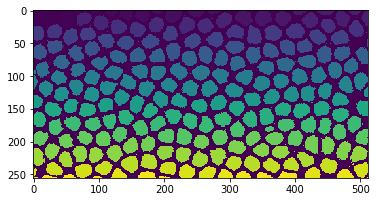

In [29]:
image = imread('/Users/prakash/Desktop/metasegData/drosophila/filtered_SEG/man_seg200.tif')
labels_per_frame = lb(image).astype(np.uint16)
from matplotlib import pyplot as plt
plt.imshow(labels_per_frame)
plt.show()
imsave(save_path+'man_seg200.tif', labels_per_frame)